In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import division, print_function, unicode_literals

from abipy import abilab
from abipy.abilab import abiopen
# Import abipy reference data.
import abipy.data as abidata

# This line configures matplotlib to show figures embedded in the notebook, instead of poping up a new window. 
# Don't use this line in your scripts!
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Create an ABINIT input file with one dataset. 
# Pseudos are located in the pseudo_dir directory.
inp = abilab.AbiInput(pseudos="14si.pspnc", pseudo_dir=data.pseudo_dir, ndtset=1)

# One can set the value of the variables directly with the syntax.
inp.ecut = 10.
inp.tolwfr = 1e-8

# One can create a python dictionary:
unit_cell = {
    "acell": 3*[10.217],       
    'rprim': [ [.0, .5, .5],
               [.5, .0, .5],
               [.5, .5, .0]],
    'ntypat': 1,
    'znucl': [14,],
    'natom': 2,
    'typat': [1, 1],
    'xred': [ [.0, .0, .0],
              [.25,.25,.25] ]
}

# and set the variables in the input file with the method (note the **)
inp.set_variables(**unit_cell)

# Alternatively, it's possible to create a dictionary on the fly with the syntax.
inp.set_variables(kptopt=1, 
                  ngkpt=[2, 2, 2], 
                  nshiftk=1, 
                  shiftk=[0.0, 0.0, 0.0]
                  )

# To print the input to stdout use:
print(inp)

ngkpt_list = [(2, 2, 2), (4, 4, 4), (6, 6, 6), (8, 8, 8)]

work = abilab.Workflow()
work.register_scf_task(inp)

work.start()

In [2]:
def ngkpt_flow():
    ngkpt_list = [(2, 2, 2), (4, 4, 4), (6, 6, 6), (8, 8, 8)]

    inp = abilab.AbiInput(pseudos=abidata.pseudos("14si.pspnc"), ndtset=len(ngkpt_list))
    structure = inp.set_structure_from_file(abidata.cif_file("si.cif"))

    # Global variables
    inp.set_variables(ecut=10, tolvrs=1e-9)

    for i, ngkpt in enumerate(ngkpt_list):
        inp[i+1].set_kmesh(ngkpt=ngkpt, shiftk=[0,0,0])

    work = abilab.Workflow()
    for dataset in inp.split_datasets():
        work.register_scf_task(dataset)

    flow = abilab.AbinitFlow(workdir="flow_ngkpt", manager=abilab.TaskManager.from_user_config())
    flow.register_work(work)
    flow.allocate()
    flow.build()

    #flow.rapidfire()
    flow.make_scheduler().start()
    flow.show_status()

    table = abilab.PrettyTable(["nkibz", "etotal"])

    for task in flow[0]:
        gsr = task.read_gsr()
        table.add_row([len(gsr.kpoints), gsr.energy])

    #print(table)
    #table.plot("nkibz", "etotal", title="etotal vs nkibz")
    return flow, table

In [3]:
flow, table = ngkpt_flow()

print(table)
table.plot()

[Mon Nov 10 14:06:34 2014] Number of launches: 4

Work #0: <Workflow, workdir=flow_ngkpt/w0>, Finalized=False

+------+-----------+---------------+------------------+---------------+---------+---------+-------+
| Task |   Status  |    Queue-id   | MPI|OMP|Mem/proc | Err|Warn|Comm |  Class  | Restart | Etime |
+------+-----------+---------------+------------------+---------------+---------+---------+-------+
|  t0  | Submitted | 784@localhost |      0|1|0       |    2|1|2.0    | ScfTask |    0    |  None |
|  t1  | Submitted | 793@localhost |      0|0|0       |    2|1|2.0    | ScfTask |    0    |  None |
|  t2  | Submitted | 802@localhost |      0|0|0       |    2|1|2.0    | ScfTask |    0    |  None |
|  t3  | Submitted | 811@localhost |      0|0|0       |    2|1|2.0    | ScfTask |    0    |  None |
+------+-----------+---------------+------------------+---------------+---------+---------+-------+


Work #0: <Workflow, workdir=flow_ngkpt/w0>, Finalized=True

+------+-----------+-------


Work #0: <Workflow, workdir=flow_ngkpt/w0>, Finalized=True

+------+-----------+---------------+------------------+---------------+---------+---------+-------+
| Task |   Status  |    Queue-id   | MPI|OMP|Mem/proc | Err|Warn|Comm |  Class  | Restart | Etime |
+------+-----------+---------------+------------------+---------------+---------+---------+-------+
|  t0  | Completed | 784@localhost |      0|1|0       |    2|1|2.0    | ScfTask |    0    |  None |
|  t1  | Completed | 793@localhost |      0|0|0       |    2|1|2.0    | ScfTask |    0    |  None |
|  t2  | Completed | 802@localhost |      0|0|0       |    2|1|2.0    | ScfTask |    0    |  None |
|  t3  | Completed | 811@localhost |      0|1|0       |    2|1|2.0    | ScfTask |    0    |  None |
+------+-----------+---------------+------------------+---------------+---------+---------+-------+

+-------+--------+
| nkibz | etotal |
+-------+--------+
|   3   |  0.0   |
|   8   |  0.0   |
|   16  |  0.0   |
|   29  |  0.0   |
+----

TypeError: plot() missing 2 required positional arguments: 'xname' and 'yname'

In [17]:
def relax_flow():
    # Structural relaxation
    ngkpt_list = [(2, 2, 2), (4, 4, 4)]
    inp = abilab.AbiInput(pseudos=abidata.pseudos("14si.pspnc"), ndtset=len(ngkpt_list))
    structure = inp.set_structure_from_file(abidata.cif_file("si.cif"))

    # Global variables
    inp.set_variables(
        ecut=10,
        tolvrs=1e-9,
        optcell=1,
        ionmov=3,
        ntime=10,
        dilatmx=1.05,
        ecutsm=0.5,
    )

    for i, ngkpt in enumerate(ngkpt_list):
        inp[i+1].set_kmesh(ngkpt=ngkpt, shiftk=[0,0,0])

    work = abilab.Workflow()
    for dataset in inp.split_datasets():
        #print(dataset)
        work.register_relax_task(dataset)

    flow = abilab.AbinitFlow(workdir="flow_relax", manager=abilab.TaskManager.from_user_config())
    flow.register_work(work)
    flow.allocate()
    flow.build()

    flow.make_scheduler().start()
    flow.show_status()

    table = abilab.PrettyTable(["nkibz", "abc", "angles", "volume"])

    for task in flow[0]:
        gsr = task.read_gsr()
        lattice = gsr.structure.lattice
        table.add_row([len(gsr.kpoints), lattice.abc[0], lattice.angles[0], lattice.volume])
    return flow, table

In [18]:
flow, table = relax_flow()
print(table)


Work #0: <Workflow, workdir=flow_relax/w0>, Finalized=True

+------+-----------+----------+------------------+---------------+-----------+---------+-------+
| Task |   Status  | Queue-id | MPI|OMP|Mem/proc | Err|Warn|Comm |   Class   | Restart | Etime |
+------+-----------+----------+------------------+---------------+-----------+---------+-------+
|  t0  | Completed |   None   |      0|1|0       |    1|1|2.0    | RelaxTask |    0    |  None |
|  t1  | Completed |   None   |      0|0|0       |    1|1|2.0    | RelaxTask |    0    |  None |
+------+-----------+----------+------------------+---------------+-----------+---------+-------+


Work #0: <Workflow, workdir=flow_relax/w0>, Finalized=True

+------+-----------+----------+------------------+---------------+-----------+---------+-------+
| Task |   Status  | Queue-id | MPI|OMP|Mem/proc | Err|Warn|Comm |   Class   | Restart | Etime |
+------+-----------+----------+------------------+---------------+-----------+---------+-------+
|  t

AttributeError: 'module' object has no attribute 'PrettyTable'

In [12]:
def bands_flow():
    inp = abilab.AbiInput(pseudos=abidata.pseudos("14si.pspnc"), ndtset=2)
    structure = inp.set_structure_from_file(abidata.cif_file("si.cif"))

    # Global variables
    inp.ecut = 10

    # Dataset 1
    inp[1].set_variables(tolvrs=1e-9)
    inp[1].set_kmesh(ngkpt=[4,4,4], shiftk=[0,0,0])

    # Dataset 2
    inp[2].set_variables(tolwfr=1e-15)
    inp[2].set_kpath(ndivsm=5)

    scf_input, nscf_input = inp.split_datasets()

    flow = abilab.bandstructure_flow(workdir="flow_bands", manager=abilab.TaskManager.from_user_config(), scf_input=scf_input, nscf_input=nscf_input)
    flow.build_and_pickle_dump()

    flow.make_scheduler().start()
    flow.show_status()
    
    nscf_task = flow[0][1]
    gsr = nscf_task.read_gsr()
    gsr.ebands.plot()

Starting job # 0 in a separate thread.


<BackgroundJob #0: <function bands_flow at 0x107bcd9d8>>


Work #0: <BandStructureWorkflow, workdir=flow_bands/w0>, Finalized=True

+------+-----------+----------+------------------+---------------+----------+---------+-------+
| Task |   Status  | Queue-id | MPI|OMP|Mem/proc | Err|Warn|Comm |  Class   | Restart | Etime |
+------+-----------+----------+------------------+---------------+----------+---------+-------+
|  t0  | Completed |   None   |      0|0|0       |    1|1|2.0    | ScfTask  |    0    |  None |
|  t1  | Completed |   None   |      0|1|0       |    1|1|2.0    | NscfTask |    0    |  None |
+------+-----------+----------+------------------+---------------+----------+---------+-------+


Work #0: <BandStructureWorkflow, workdir=flow_bands/w0>, Finalized=True

+------+-----------+----------+------------------+---------------+----------+---------+-------+
| Task |   Status  | Queue-id | MPI|OMP|Mem/proc | Err|Warn|Comm |  Class   | Restart | Etime |
+------+-----------+----------+------------------+---------------+----------+------

+------+-----------+----------+------------------+---------------+----------+---------+-------+
| Task |   Status  | Queue-id | MPI|OMP|Mem/proc | Err|Warn|Comm |  Class   | Restart | Etime |
+------+-----------+----------+------------------+---------------+----------+---------+-------+
|  t0  | Completed |   None   |      0|0|0       |    1|1|2.0    | ScfTask  |    0    |  None |
|  t1  | Completed |   None   |      0|1|0       |    1|1|2.0    | NscfTask |    0    |  None |
+------+-----------+----------+------------------+---------------+----------+---------+-------+

old_fermie 0.0, new fermie 5.60315611834


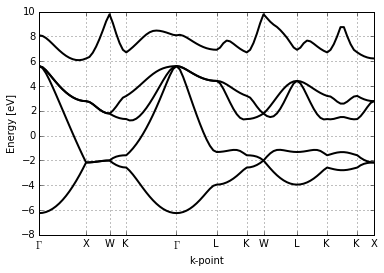

In [14]:
bands_flow()
#from IPython.lib import backgroundjobs as bg
#jobs = bg.BackgroundJobManager()
#jobs.new(bands_flow)